In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import json
import datetime
from dateutil.relativedelta import relativedelta
import gensim
from gensim import corpora, models
from gensim.models import Phrases
import numpy as np
import matplotlib.pyplot as plt
import random
from stop_words import get_stop_words
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,roc_curve,auc
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from random import shuffle

In [2]:
with open("F:/train-pos.txt",'r',encoding="utf-8") as infile:
    pos_review=infile.readlines()
with open("F:/train-neg.txt",'r',encoding="utf-8") as infile:
    neg_review=infile.readlines()
with open("F:/train-unsup.txt",'r',encoding="utf-8") as infile:
    unsup_review=infile.readlines()

In [3]:
y = np.concatenate((np.ones(len(pos_review)), np.zeros(len(neg_review))))
x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_review, neg_review)), y, test_size=0.2)

In [4]:
def cleanText(corpus):
    punctuation = """.,?!:;(){}[]"""
    corpus = [z.lower().replace('\n','') for z in corpus]
    corpus = [z.replace('<br />', ' ').strip() for z in corpus]

    #treat punctuation as individual words
    for c in punctuation:
        corpus = [z.replace(c, ' %s '%c) for z in corpus]
    corpus = [z.split() for z in corpus]
    en_stop = get_stop_words('en')
    custom_stop=['.',',',':','(',')','{','}','[',']']
    en_stop=en_stop+['can','will','shall']+custom_stop
    corpus= [[token for token in doc if not token in en_stop and not token.isdigit()]for doc in corpus]
    wnl = WordNetLemmatizer()
    texts= [[wnl.lemmatize(token) for token in doc]for doc in corpus]
    return corpus

In [5]:
x_train=cleanText(x_train)
x_test=cleanText(x_test)
unsup_review=cleanText(unsup_review)

In [6]:
def labelizeReviews(reviews, label_type):
    labelized = []
    for i,v in enumerate(reviews):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train_1 = labelizeReviews(x_train, 'TRAIN')
x_test_1 = labelizeReviews(x_test, 'TEST')
unsup_review_1 = labelizeReviews(unsup_review, 'UNSUP')

In [7]:
import random

size = 400

#instantiate our DM and DBOW models
model_dm = gensim.models.doc2vec.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=3)
model_dbow =gensim.models.doc2vec.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, dm=0, workers=3)

#build vocab over all reviews
model_dm.build_vocab((x_train_1+x_test_1+unsup_review_1))
model_dbow.build_vocab((x_train_1+x_test_1+unsup_review_1))

In [8]:
all_train_reviews = x_train_1+ unsup_review_1

In [9]:
%time model_dm.train(all_train_reviews,total_examples=62500,epochs=10)

Wall time: 5min 34s


82733625

In [10]:
model_dm.save('./imdb.d2v')

In [11]:
%time model_dbow.train(all_train_reviews,total_examples=62500,epochs=10)

Wall time: 3min 47s


82736964

In [12]:
model_dbow.save('./imdb_1.d2v')

In [13]:
#Get training set vectors from our models
def getVecs(model, corpus, size):
    vecs = [np.array(model.docvecs[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

train_vecs_dm = getVecs(model_dm, x_train_1, size)
train_vecs_dbow = getVecs(model_dbow, x_train_1, size)

train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))

In [14]:
%time model_dm.train(x_test_1,total_examples=12500,epochs=10)

Wall time: 2min 27s


5906002

In [15]:
%time model_dbow.train(x_test_1,total_examples=12500,epochs=10)

Wall time: 15.5 s


5906681

In [16]:
#Construct vectors for test reviews
test_vecs_dm = getVecs(model_dm, x_test_1, size)
test_vecs_dbow = getVecs(model_dbow, x_test_1, size)

test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

In [34]:
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss='log', penalty='l2')
lr.fit(train_vecs, y_train)
pred=lr.predict(test_vecs)
print(accuracy_score(y_test,pred))

0.8342


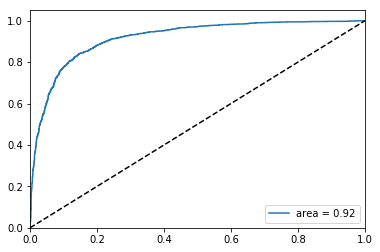

In [35]:
#Create ROC curve
%matplotlib inline
pred_probas = lr.predict_proba(test_vecs)[:,1]

fpr,tpr,_ = roc_curve(y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()